# Team Bear: got-loan model

The goal of this model is to quantify the correlation between the following two variables
- Historical GDP data per country
- Weather a country has ever gotten a loan from the World Bank

Let us emphasize the fact that our goal is to quantify correlation, as opposed to causation. This is to be expected, the World Bank determines who gets loans after careful considerations of a variety of different factors ([reference](https://www.worldbank.org/en/news/feature/2012/07/26/getting_to_know_theworldbank)) and a countries GDP is too simplistic to encode this complexity.

Nevertheless, we believe that having a good understanding of the correlation between a countries GDP and their (historical) ability to get World Bank loans, will be of interest for countries aspiring to get their loans approved. For example, while the World Bank aims to give loans to low/middle income countries to help their development, we found that having a certain level of GDP stability to be a great predictor of a countries ability to get loans.

We denote the feature that encodes GDP stability by 'volatility'. This feature was handcrafted for the problem at hand, and we believe it is the most important finding in this notebook. Please proceed to the 'Data Visualization - preprocessed data' section to learn more about the volatility feature.


Fore future reference let us record that the GDP data was extracted from the following source: [World Bank GDP per capita](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

Before diving into the model and its predictions, let us show first do a quick exploration of the raw data the World Bank provides, and explain how we pre-process the data to make it more ammenable to Machine Learning methods.

We will store the raw gdp data in a pandas DataFrame named 'gdp_raw'

In [2]:
gdp_raw = pd.read_csv('gdp.csv', header = 2)
gdp_raw.drop(columns = 'Unnamed: 65', inplace = True)
gdp_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.013919,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,147.836769,147.238537,156.426780,182.521139,162.594548,180.489043,...,1686.695763,1672.363658,1653.188436,1658.650062,1507.800256,1404.953164,1540.232473,1534.171767,1485.307425,1330.140232
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,...,591.162798,641.871438,637.165464,613.856505,578.466353,509.220100,519.888913,493.756581,507.103392,508.808409
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.963779,113.114697,118.865837,123.478967,131.892939,138.566819,...,1827.518347,1936.390962,2123.392433,2166.743309,1886.248158,1666.422406,1606.978332,1695.959215,1772.339155,1714.426800
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468219,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1895.770869


## Data Visualization - raw data

In order to be able to perform meaninful GDP analysis we would like to extract a few key features encoded in the data -- in this way we are able to simplify the analysis while preventing overfitting on the data.

Therefore, to extract meaningful features we first perform some data visualizations. The key finding of this section is that
- GDP (per capita) follows a linear trend

To justify this assertion, we can take a quick look at the World GDP and see how during the period 1960-2020 the GDP has generally followed a linear trend (see graph below).

Before going further, let us raise a criticism of this approach. As one can see in the graph below, the best fit line of the World GDP predicts that in the year 1960 the World had a negative GDP (which is impossible) -- and one could make the argument that an exponential function would be better at fitting the natural GDP trend. Nevertheless, we have sticked to the best fit line due to the following reasons:
- Simplicity. Straight lines are considerably simpler than exponential functions.
- GDP has only existed as a concept for less than one hundred years ([reference](https://en.wikipedia.org/wiki/Gross_domestic_product)), which is a small period of time in the context of human civilization. Hence, even if GDP really followed an exponential trend, we are working on a sufficiently small period of time that a linear approximation gives a comparable output.


In [3]:
from sklearn.linear_model import LinearRegression

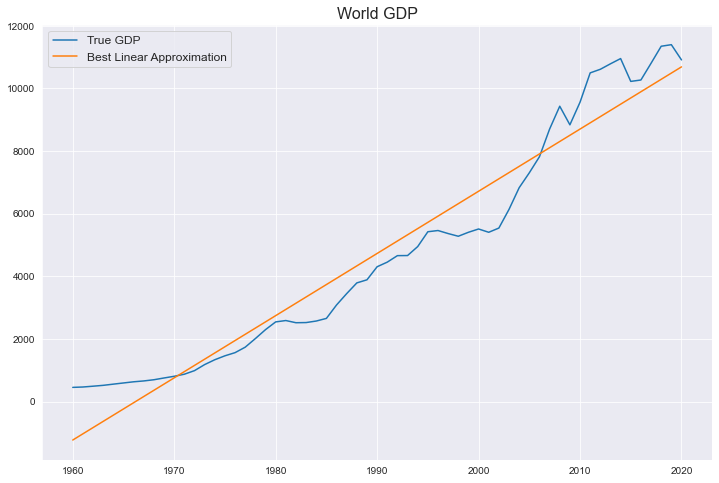

In [4]:
X_year = np.array([])
y_gdp = np.array([])
index_world = gdp_raw[gdp_raw.loc[:, 'Country Name']== 'World'].index
years = np.linspace(1960, 2020, num = 61, dtype = int)

for year in years:
# needs fixing, want to show the World GDP history. Country Name = 'World'
    if str(gdp_raw.loc[index_world, str(year)]) == 'nan':
        pass
    else:
        X_year = np.append(X_year, year)
        y_gdp = np.append(y_gdp, gdp_raw.loc[index_world, str(year)])
        
LR = LinearRegression()
LR.fit(X_year.reshape(-1,1), y_gdp)


plt.figure(figsize = (12,8))        
plt.plot(X_year, y_gdp, label = 'True GDP')
plt.plot(years.reshape(-1,1), LR.predict(years.reshape(-1,1)),  label = 'Best Linear Approximation')
plt.title('World GDP', fontsize = 16)
plt.legend(fontsize=12)

plt.show()

In [5]:
years = np.linspace(1960, 2020, num = 61, dtype = int)

def get_gdp_visualization(sample):
    
    fig, axes = plt.subplots(int(sample/2), 2 , figsize = (12,12))
    ax = axes.ravel()
    
    i = 0
    for index in gdp_raw.sample(sample).index:
        X_year = np.array([])
        y_gdp = np.array([])
        #print(gdp_raw.loc[index, 'Country Name'])
        for year in years:
            if str(gdp_raw.loc[index, str(year)]) == 'nan':
                pass
            else:
                X_year = np.append(X_year, year)
                y_gdp = np.append(y_gdp, gdp_raw.loc[index, str(year)])
        
        if len(X_year)>0:
            lr = LinearRegression()
            lr.fit(X_year.reshape(-1,1), y_gdp) 
            
            ax[i].plot(X_year, y_gdp, label = 'True GDP')
            ax[i].plot(years.reshape(-1,1), lr.predict(years.reshape(-1,1)), label = 'Best Linear Approximation')
            ax[i].set_title(gdp_raw.loc[index, 'Country Name'], fontsize = 16)
            ax[i].legend(fontsize=12)
            i = i+1
        
    fig.tight_layout()

**Is Linear Regression really enough?**

Even though performing a linear regression on the historical GDP data proved to be a good approximation for the aggregate World GDP, for each individual country a simple linear regression is too simplistic to encode all the complexity encoded in the GDP data -- as seen in the following examples.

To fix this problem, we introduce a new feature which we call 'GDP volatility' (or just 'volatility' for short), whose goal is to capture how far away is the real GDP data from the best linear approximation. As we will see in the next section, the variance in volatility between countries who got loans is very small when compared to the variance in volatility between countries who did not get loans. Ultimately, we believe that this is what makes this model work.

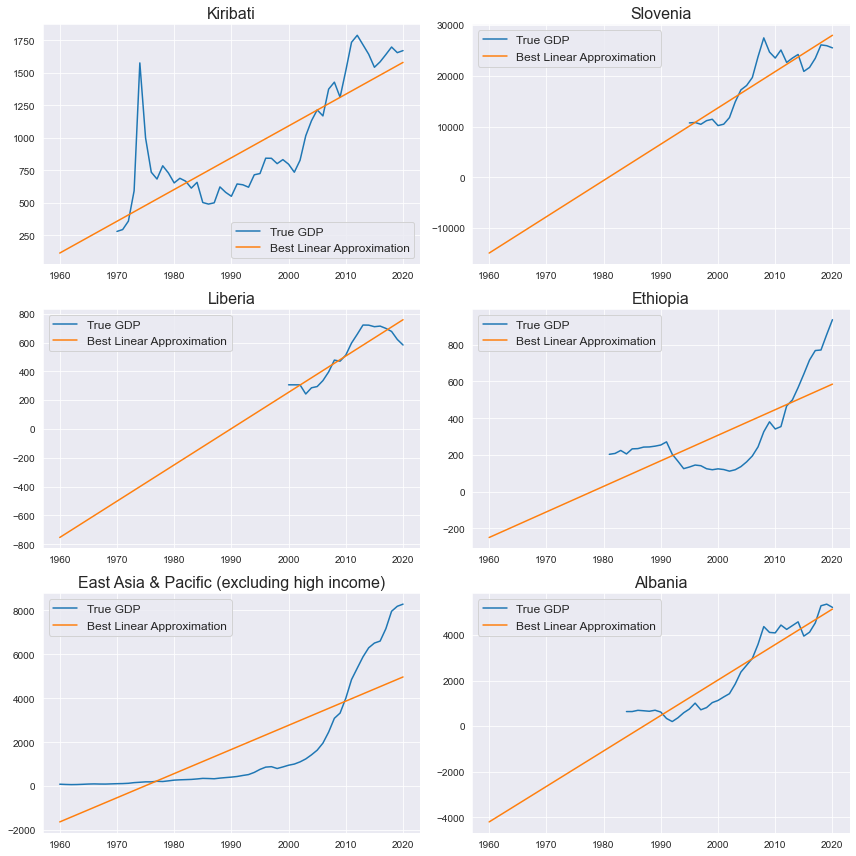

In [6]:
#Only works for a even number of samples
get_gdp_visualization(6)

## Data Visualization - preprocessed data

The goal of this section is two fold:
- Perform data visualizations on the refined GDP data set, which is stored on the gdp_df Data Frame
- Explain how the GDP volatility is extracted from the raw GDP data

Lets begin by explaning the features we will find in the gdp_df Data Frame:
- Slope and y_intercept were extracted from the 'best fit line' we obtained when we performed the linear regression on the GDP data for each country. As one can see in the vizualization below, slope and y_intercept are highly correlated. This is due to the fact that the GDP data is 'centered' in the years 1960-2020, while the y_intercept happens at the year zero; hence, due to the magnitudes involved, the y_intercept is mostly determined by the slope.
- Volatility is a variation of the root mean squared error between the true GDP data and the linear regression. However, due to the different GDP magnitudes among countries it is necessary to normalize the root mean squared error to obtain a meaningful feature.
- min_year and max_year are the minimum and maximum years for which we have the GDP for each country (earlierst being 1960, and latest being 2020).
- Political Stability was directly obtained from the World Bank ([reference](https://info.worldbank.org/governance/wgi/)) and it reports on aggregate and individual governance indicators for over 200 countries and territories over the period 1996–2020, for six dimensions of governance: Voice and Accountability, Political Stability and Absence of Violence/Terrorism, Government Effectiveness, Regulatory Quality, Rule of Law, and Control of Corruption.

Finally, recall that the goal of this notebook is to perform a classification task on weather a country has ever gotten a loan from the World Bank based on their GDP characteristics. Fortunately, we have a well balanced data set to train our model on: about 55% of countries have gotten loans from the World Bank.

In [7]:
gdp_df = pd.read_csv('gdp_analysis.csv')
X = gdp_df.loc[:,['slope', 'y_intercept', 'volatility', 'min_year', 'max_year']]
#X = gdp_df.loc[:,['slope', 'volatility', 'max_year']]
y = gdp_df.loc[:, 'got_loan']
#y = gdp_df.loc[:, 'got_mentioned']

In [8]:
print('Percentage of countries who got loans from the WorldBank:', 
      np.round(np.mean(gdp_df.got_loan.values),2))
print('Percentage of countries who got mentioned in WorldBank loan documents:', 
      np.round(np.mean(gdp_df.got_mentioned.values),2))

Percentage of countries who got loans from the WorldBank: 0.57
Percentage of countries who got mentioned in WorldBank loan documents: 0.83


In [9]:
gdp_df.head()

,country_name,slope,y_intercept,volatility,min_year,max_year,political_stability,got_loan,got_mentioned
0,afghanistan,7.675012,-1.497918e+04,0.540344,1960.0,2020.0,-2.479,0.0,0.0
1,albania,155.758189,-3.094915e+05,0.370373,1984.0,2020.0,-0.097,1.0,1.0
2,algeria,76.377837,-1.498252e+05,0.568859,1960.0,2020.0,-1.250,1.0,1.0
3,american samoa,228.691323,-4.494300e+05,0.597126,2002.0,2019.0,0.000,0.0,0.0
4,andorra,918.360834,-1.809247e+06,0.385188,1970.0,2019.0,1.349,0.0,0.0


As we can see from the next plot, most of the countries that have gotten loans from the World Bank seem to share a lot of common feaures when it comes to their GDP -- potentially showing some sort of bias in the way World Bank loans are distributed. Furthermore, we want to emphasize the success that the volatility feature (developed as part of the project) seems to have for predicting if a country has gotten a world bank loan.

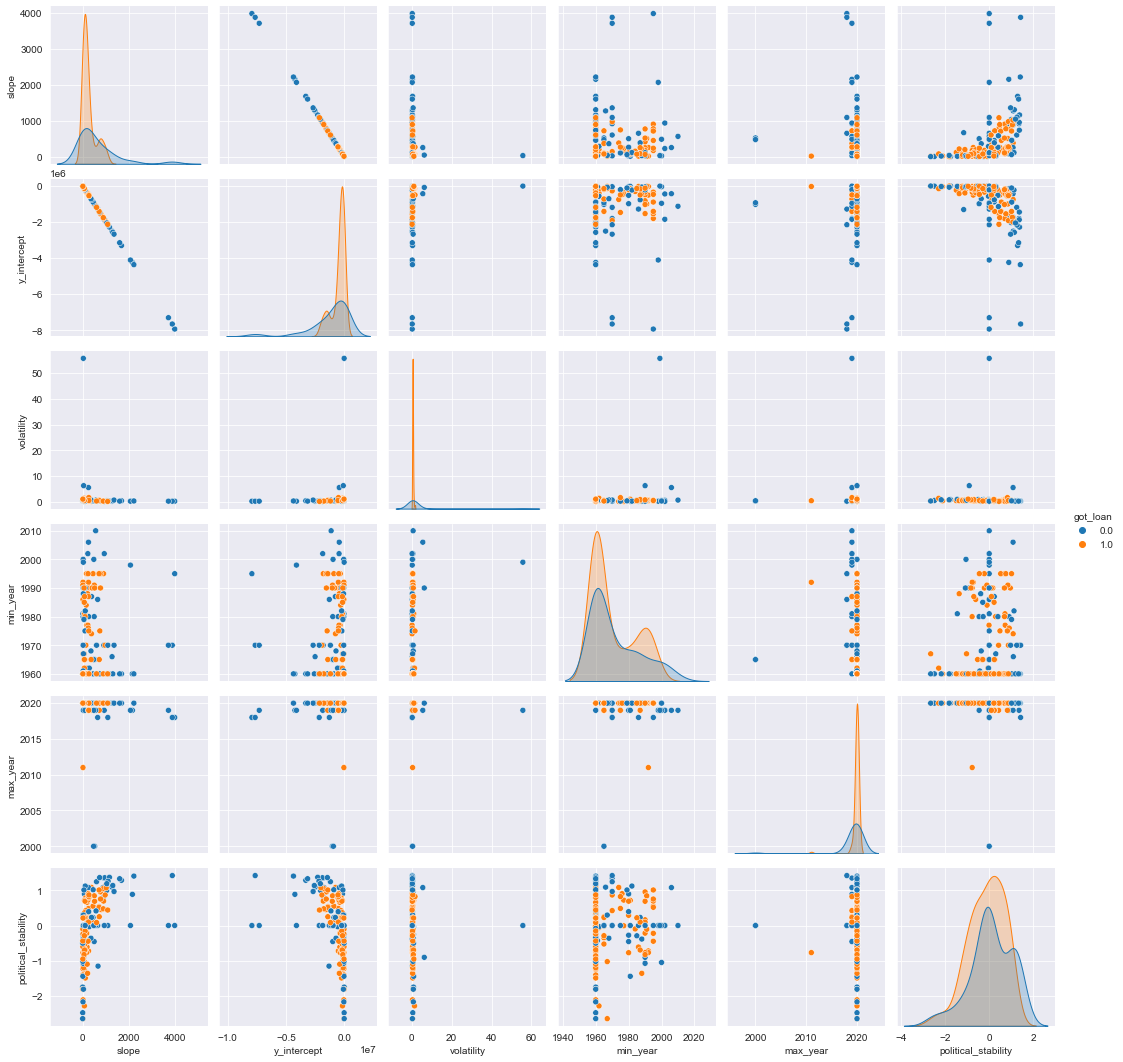

In [10]:
sns.pairplot(gdp_df, vars = ['slope', 'y_intercept', 'volatility',
                             'min_year', 'max_year', 'political_stability'], hue = 'got_loan')

plt.show()

However, despite the apparent success of the volatility feature, we would like to advise caution when using these features since they still appear to be highly noisy. To illustrate the limitations of the features we plot some histogram diagrams below to show just how noisy the data still is.

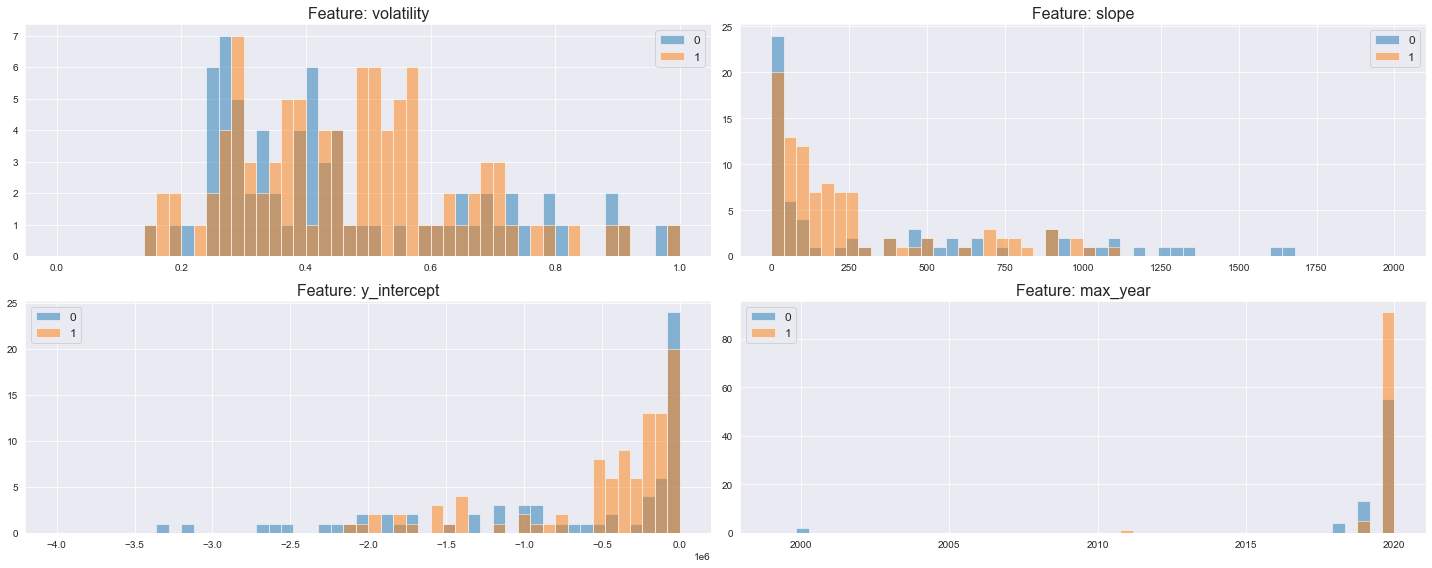

In [11]:
fig, axes = plt.subplots(2,2, figsize = (20,8))
ax = axes.ravel()

ax[0].hist(gdp_df[gdp_df.got_loan == 0.0].volatility, alpha = 0.5, range = (0,1), bins =50, label = '0')
ax[0].hist(gdp_df[gdp_df.got_loan == 1.0].volatility, alpha = 0.5,range = (0,1), bins = 50, label = '1')
ax[0].set_title('Feature: volatility', fontsize = 16)
ax[0].legend(fontsize=12)

ax[1].hist(gdp_df[gdp_df.got_loan == 0.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '0')
ax[1].hist(gdp_df[gdp_df.got_loan == 1.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '1')
ax[1].set_title('Feature: slope', fontsize = 16)
ax[1].legend(fontsize=12)

ax[2].hist(gdp_df[gdp_df.got_loan == 0.0].y_intercept, alpha = 0.5, range = (-4*(10**6),0), bins =50, label = '0')
ax[2].hist(gdp_df[gdp_df.got_loan == 1.0].y_intercept, alpha = 0.5,range = (-4*(10**6),0), bins = 50, label = '1')
ax[2].set_title('Feature: y_intercept', fontsize = 16)
ax[2].legend(fontsize=12)

ax[3].hist(gdp_df[gdp_df.got_loan == 0.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '0')
ax[3].hist(gdp_df[gdp_df.got_loan == 1.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '1')
ax[3].set_title('Feature: max_year', fontsize = 16)
ax[3].legend(fontsize=12)

fig.tight_layout()

**On Volatility**

Before finishing this section lets us explain how to obtain the volatility feature from the raw GDP data. Recall quickly that volatility is simply a normalized root mean squared error between the best fit line and the true GDP data. The normalization is performed to take into account the vastly different GDP's various countries have. The process is as follows:
- First, we fit a StandardScaler on the 'best fit line' for each country.
- We then transform using the fitted Standard scaler the best fit line and the true GDP data.
- Finally, we compute the root mean squared error between the normalized best fit line and the normalized GDP data.


## Machine Learning Models

Finally, we would like to actually quantify the predictive power of these features. Various classification models have been tested against the data set, but ultimately RandomForestsClassifier had the best performance -- after some hyperparameter tuning.


In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.base import clone

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, shuffle = True)

In [30]:
skf = StratifiedKFold(n_splits = 20)
cv = np.zeros((20,4))

rf = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)

i = 0
for train_index, val_index in skf.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_train_train = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]
    
    rf_clone = clone(rf)
    rf_clone.fit(X_train_train, y_train_train)
    
    cv[i, 0] = accuracy_score(y_val, rf_clone.predict(X_val))
    cv[i,1] = roc_auc_score(y_val, rf_clone.predict_proba(X_val)[:,1])
    
    cv[i,2] = accuracy_score(y_val, np.ones(len(y_val)))
    cv[i,3] = roc_auc_score(y_val, np.ones(len(y_val)))

    i = i + 1

    
cv_mean = np.mean(cv, axis = 0)

print('The following scores where computed agains the validation set.')
print('Mean accuracy score for Random Forest: ', np.round(cv_mean[0], 2))
print('Mean roc auc score for Random Forest: ', np.round(cv_mean[1],2))
print('Mean accuracy score for base model: ', np.round(cv_mean[2],2))
print('Mean roc auc score for base model: ', np.round(cv_mean[3],2))

The following scores where computed agains the validation set.
Mean accuracy score for Random Forest:  0.66
Mean roc auc score for Random Forest:  0.77
Mean accuracy score for base model:  0.57
Mean roc auc score for base model:  0.5


In [31]:
rf_test = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)
rf_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, n_estimators=60)

In [32]:
print('The following scores where computed agains the test set.')
print('Accuracy score for Random Forest: ', np.round(accuracy_score(y_test, rf_test.predict(X_test)), 2))
print('Roc auc score for Random Forest: ', np.round(roc_auc_score(y_test, rf_test.predict_proba(X_test)[:,1]), 2))

The following scores where computed agains the test set.
Accuracy score for Random Forest:  0.69
Roc auc score for Random Forest:  0.79
